In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import Imputer, StandardScaler

# Modeling
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from math import log

Z:\Users\Don\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Z:\Users\Don\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(df_train.shape, df_test.shape)
df_train.head()

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


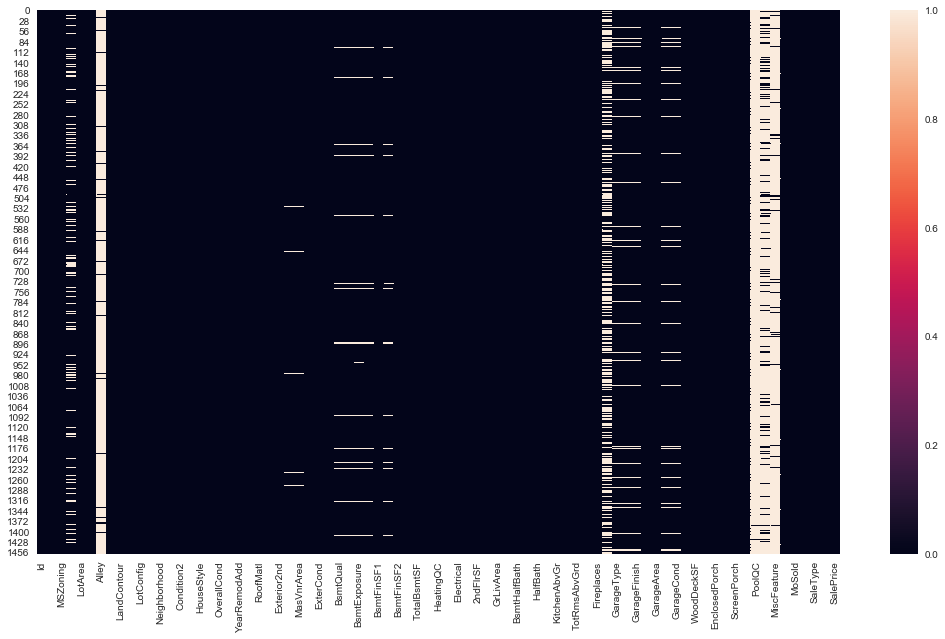

In [4]:
"Visualizing null values"
plt.figure(figsize=(18,10))
sns.heatmap(df_train.isnull())

# Cleaning

In [5]:
def cleaning(df_train, df_test, opt):
    
    trainData = df_train.copy()
    testData = df_test.copy()

    df_temp = (trainData
                  .append(testData, sort=True)
                  .set_index('Id'))
    X_temp = df_temp.drop('SalePrice', axis=1)
    y_temp = df_temp['SalePrice']
    
    ######################################################
    "Custom Modifications"
    X_temp['MSSubClass'] = X_temp['MSSubClass'].astype('str')
    #X_temp['OverallQual'] = X_temp['OverallQual'].astype('str')
    #X_temp['OverallCond'] = X_temp['OverallCond'].astype('str')
    #X_temp['BsmtHalfBath'] = X_temp['BsmtHalfBath'].astype('str') 
    #X_temp['BsmtFullBath'] = X_temp['BsmtFullBath'].astype('str') 
    #X_temp['HalfBath'] = X_temp['HalfBath'].astype('str') 
    #X_temp['FullBath'] = X_temp['FullBath'].astype('str')
    #X_temp['BedroomAbvGr'] = X_temp['BedroomAbvGr'].astype('str') 
    #X_temp['GarageCars'] = X_temp['GarageCars'].astype('str') 
    #X_temp['KitchenAbvGr'] = X_temp['KitchenAbvGr'].astype('str')
    ######################################################
    
    X_numericals = X_temp.select_dtypes(include=['int64', 'float64'])
    X_categories = X_temp.columns[X_temp.dtypes == 'object'].tolist()  

    #for col in nulls:
    #    df[col + '_was_missing'] = df[col].isnull()
   
    if opt == 1:
        ### Substituting null values with mean values and dropping categorical columns###
        X_temp = DataFrameImputer().fit_transform(X_temp)
        scaler = StandardScaler().fit(X_temp[X_numericals.columns])
        X_temp[X_numericals.columns] = scaler.transform(X_temp[X_numericals.columns])
        X_temp = X_temp.drop(X_categories, axis=1)

        #################################################
    else:
        X_temp = DataFrameImputer().fit_transform(X_temp)
        scaler = StandardScaler().fit(X_temp[X_numericals.columns])
        X_temp[X_numericals.columns] = scaler.transform(X_temp[X_numericals.columns])

        X_temp = pd.get_dummies(X_temp) 
    
    X_train = X_temp.loc[trainData['Id']]
    X_test = X_temp.loc[testData['Id']]
    y_train = y_temp.loc[trainData['Id']]
    y_test = y_temp.loc[testData['Id']]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = cleaning(df_train, df_test, 2)
    
X_train2, X2, y_train2, y2 = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
X_cv, X_test2, y_cv, y_test2 = train_test_split(X2, y2, test_size=0.5, random_state=42)

print('training', X_train2.shape)  
print('CV      ', X_cv.shape)
print('testing ', X_test2.shape)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

training (876, 303)
CV       (292, 303)
testing  (292, 303)


((1460, 303), (1460,), (1459, 303), (1459,))

### Feature Selection

In [6]:
housing = pd.concat([X_train, y_train], axis=1)
corrColumns = (housing.corr()['SalePrice']
                    .sort_values(ascending=False)
                    .head(70) # experiment with amount of features to decrease Bias
                    .index)
X_train = housing[corrColumns].drop('SalePrice', axis=1)
X_train.insert(1,0, 1)
X_train3, X3, y_train3, y3 = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
X_cv, X_test3, y_cv, y_test3 = train_test_split(X3, y3, test_size=0.5, random_state=42)

X_train3.shape, X_cv.shape, X_test2.shape

((876, 70), (292, 70), (292, 303))

### Modeling - Linear Regression

In [7]:
lr = LinearRegression()
lr.fit(X_train3, y_train3)

y_predtrain = lr.predict(X_train3)
y_predcv = lr.predict(X_cv)
y_predtest = lr.predict(X_test3)

print('Average training error = ', "{:,}".format(mean_squared_error(y_train2, y_predtrain)))
print('Average testing error =  ' , "{:,}".format(mean_squared_error(y_cv, y_predcv)))
print('Testing accuracy =       ', "{:,}".format(mean_squared_error(y_test2, y_predtest)))

Average training error =  744,128,353.3527397
Average testing error =   1,429,989,065.1541095
Testing accuracy =        722,354,887.5068493


### Functions

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(X, y, theta, lam=0):
    m = len(y)
    h = X.dot(theta)
    y = y.values.reshape(m,1)
    reg = (lam * np.power(theta, 2).sum()) / (2 * m)
    J = np.power(h - y, 2).sum() / (2*m) + reg
    return round(J[0],2)

def grad(X, y, theta, lam=0):    
    m = len(y)
    h = X.dot(theta)
    y = y.values.reshape(m,1)
    alpha = 0.01                    # Make sure to adjust this value when changing number of features
    theta = (theta * (1 - (alpha * lam / m))) - (alpha/m) * np.matmul(X.T, (h - y))
    return theta

### Optimizing Lambda

In [9]:
lams = [0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.3, 0.6, 1.2, 2.4, 4.8, 9.6, 20, 40, 100]
for j in lams:
    theta_temp = np.zeros([X_train3.shape[1], 1])
    for i in range(1000):
        theta_temp = grad(X_train3, y_train3, theta_temp, j)
    print('Cost for lambda', j,' = ', cost(X_cv, y_cv, theta_temp, j))

Cost for lambda 0  =  808341384.64
Cost for lambda 0.01  =  808450077.47
Cost for lambda 0.02  =  808558764.46
Cost for lambda 0.04  =  808776120.9
Cost for lambda 0.08  =  809210763.63
Cost for lambda 0.16  =  810079768.75
Cost for lambda 0.3  =  811599629.35
Cost for lambda 0.6  =  814852633.07
Cost for lambda 1.2  =  821343008.39
Cost for lambda 2.4  =  834261859.98
Cost for lambda 4.8  =  859856909.25
Cost for lambda 9.6  =  910114481.91
Cost for lambda 20  =  1015078396.45
Cost for lambda 40  =  1204061131.02
Cost for lambda 100  =  1701057620.68


### Optimizing Theta

In [10]:

train_sizes = [1,100,200,300,400,500,600,700,800,876]

J = []
J2 = []
for i in train_sizes:
    X = X_train3.iloc[:i,:]
    y = y_train3.iloc[:i]
    theta = np.zeros([X.shape[1], 1])
    for i in range(1000):
        theta = grad(X, y, theta, 0)        #Training linear regression model
    J.append(cost(X, y, theta,0))          #Calculating cost function on training data
    J2.append(cost(X_cv, y_cv, theta,0))   #Calculating cost function on testing data

### Learning Curve

training error =  470,961,931.0
cv error =  808,341,384.64
Gap =  337,379,453.62


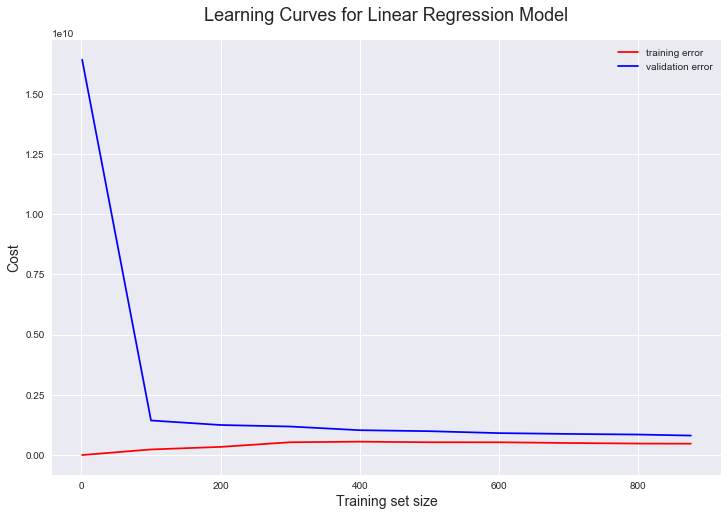

In [11]:
plt.figure(figsize=[12,8])
plt.plot(train_sizes,J, color='r', label= 'training error')
plt.plot(train_sizes,J2, color='b', label= 'validation error')

plt.ylabel('Cost', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title("Learning Curves for Linear Regression Model", fontsize=18, y=1.03)
plt.legend()

print('training error = ', "{:,}".format(round(J[-1]),2))
print('cv error = ', "{:,}".format(round(J2[-1], 2)))
print('Gap = ', "{:,}".format(round(J2[-1]-J[-1], 2)))

#test_err = cost(X_test2, y_test2, theta, 0)
#print('test error = ', "{:,}".format(round(test_err, 2)))

# training error =  470,961,931.0 
# best cv score 808,341,384.64 
# test error =  394,765,794.38

training score 
 [-0.00000000e+00  4.77336713e+08  6.30247349e+08  7.30326678e+08
  7.23337077e+08  7.59125311e+08  7.74498049e+08]
validation score 
 [1.25801601e+10 1.77012016e+30 1.25473041e+28 7.24341249e+26
 1.16299134e+09 1.07728093e+09 1.03811501e+09]


training score converges at 774498049.1082191
validation score converges at 1038115007.4260275


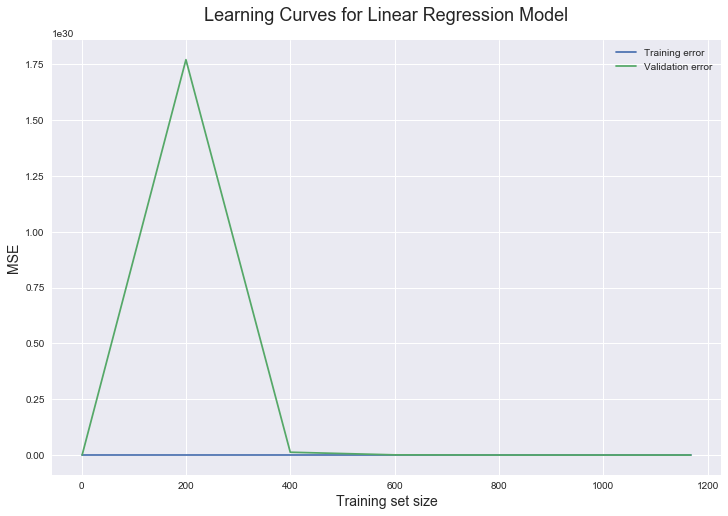

In [12]:
#train_sizes = list(range(1,1168,50))
train_sizes = [1,200,400,600,800,1000,1168]

train_sizes, train_scores, validation_scores = learning_curve(estimator = LinearRegression(),
                                                              X = X_train, 
                                                              y = y_train, 
                                                              train_sizes = train_sizes, 
                                                              cv = 5, 
                                                              scoring = 'neg_mean_squared_error',
                                                              shuffle = True)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)

plt.figure(figsize=[12,8])
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, validation_scores_mean, label='Validation error')


plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title("Learning Curves for Linear Regression Model", fontsize=18, y=1.03)
plt.legend()
#plt.ylim(0,0.05)

print('training score','\n', train_scores_mean)
print('validation score','\n', validation_scores_mean)
print('\n')
print('training score converges at', train_scores_mean[-1])
print('validation score converges at', validation_scores_mean[-1])

#training score converges at 1159681687.35
#validation score converges at 1366749239.20


### Submission

In [13]:
#X_test = X_test[corrColumns[1:]]
#y_pred = X_test.dot(theta).rename(columns={0: 'SalePrice'})
#y_pred.to_csv('prediction.csv')



# Presentation Visuals

Text(0.5,1,'Importance of Housing Features')

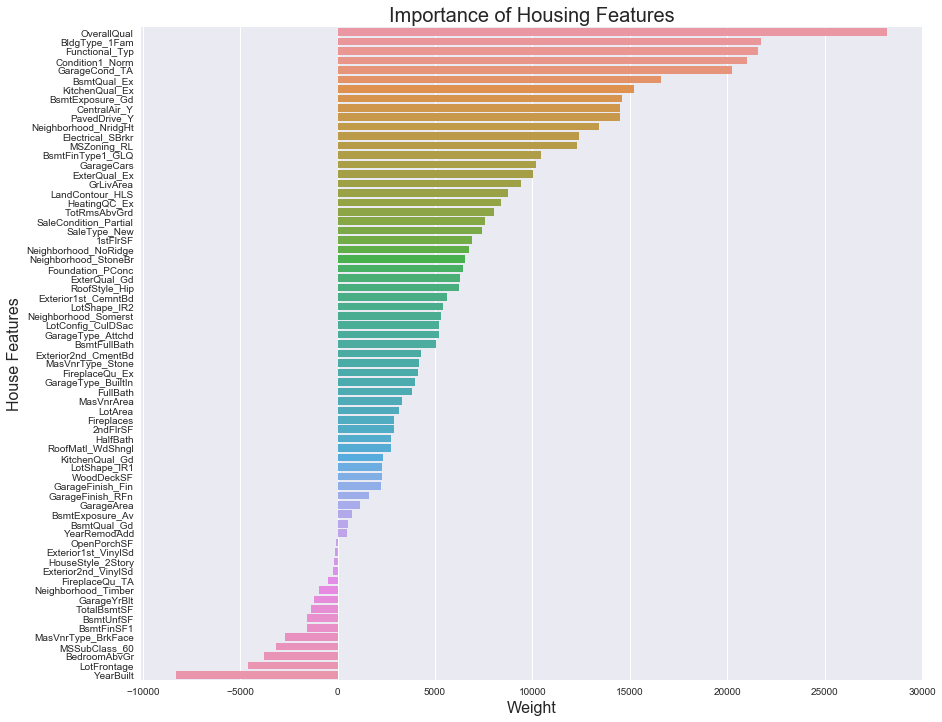

In [14]:
features = pd.DataFrame(theta[1:], columns = ['Weight'])
features.insert(0, 'features', corrColumns[1:])
features = features.sort_values(by='Weight', ascending=False)

plt.figure(figsize=(14,12))
sns.barplot(y='features', x='Weight', data=features)

plt.xlabel('Weight', fontsize=16)
plt.ylabel('House Features', fontsize=16)
plt.title('Importance of Housing Features', fontsize=20)


Text(0.5,1,'Importance of Housing Features')

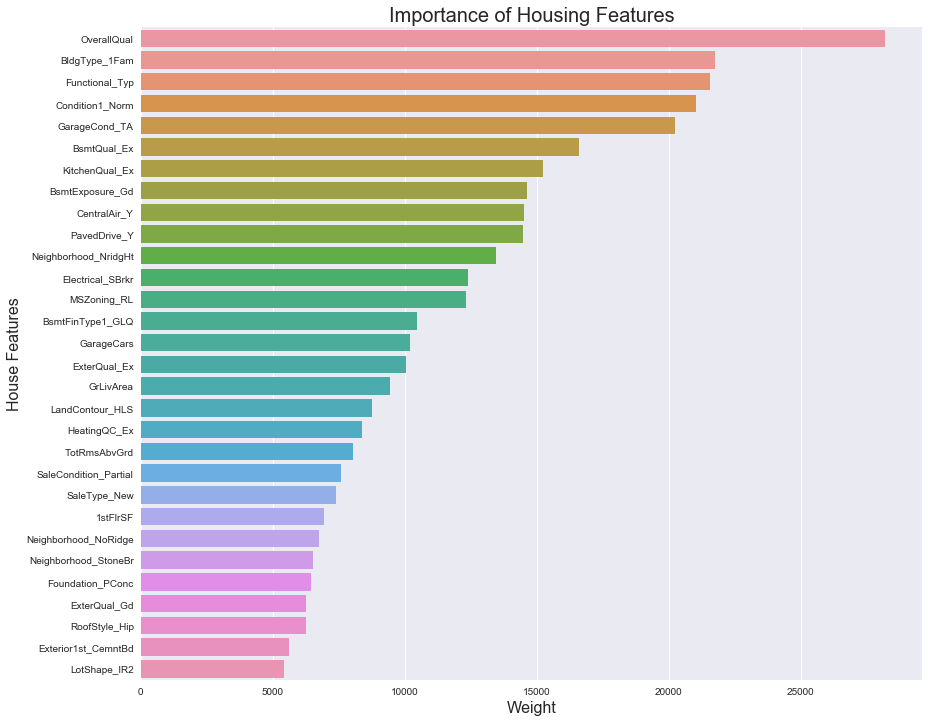

In [15]:
plt.figure(figsize=(14,12))
sns.barplot(y='features', x='Weight', data=features.head(30))

plt.xlabel('Weight', fontsize=16)
plt.ylabel('House Features', fontsize=16)
plt.title('Importance of Housing Features', fontsize=20)

Z:\Users\Don\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'SalePrice (Thousand)')

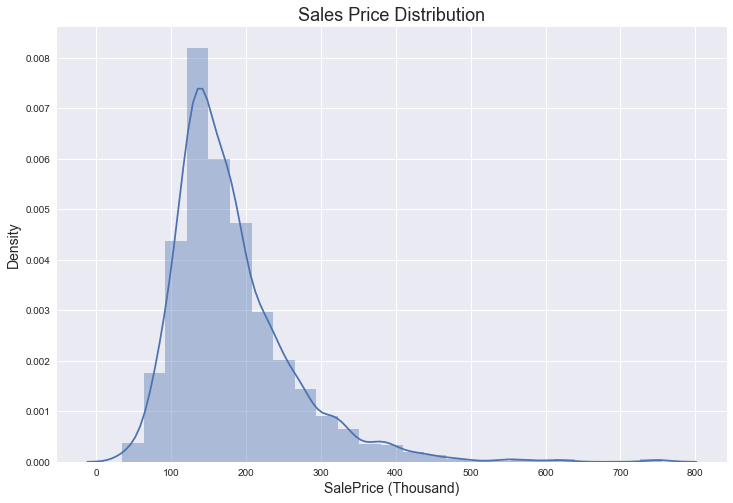

In [16]:
"SalePrice Distribution"
plt.figure(figsize=[12,8])

plt.ylabel('Density', fontsize=14)
plt.title('Sales Price Distribution', fontsize=18)
sns.distplot(y_train/1000, bins=25)
plt.xlabel('SalePrice (Thousand)', fontsize=14)

In [17]:
np.sqrt(cost(X_test3, y_test3, theta, 0))

19868.71395888521

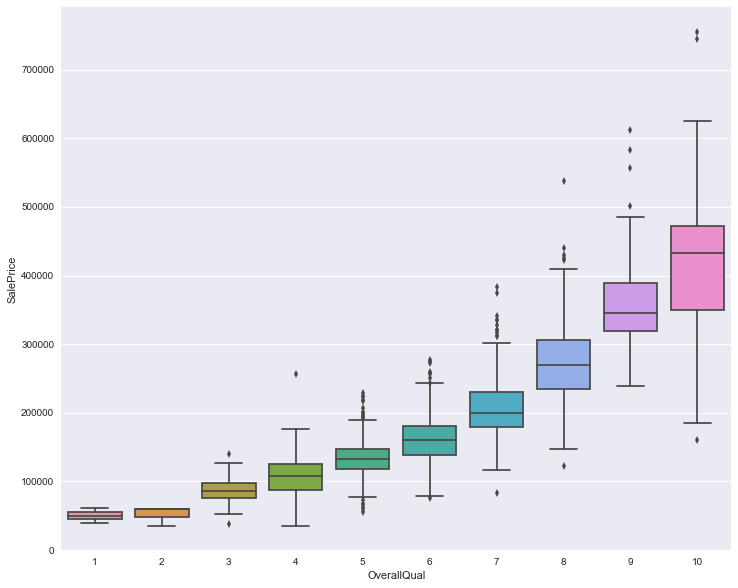

In [18]:
plt.figure(figsize=(12,10))
sns.boxplot(data=df_train, x='OverallQual', y='SalePrice')